https://github.com/sinchir0/automated_essay_scoring/blob/main/automated_essay_scoring/exp/exp006.ipynb

#  目的
回帰を解くようにする、回帰→Classは NelderMead 法を用いる。

In [1]:
# path setting
EXP_NAME = "e007-add-n"
MODEL_NAME = "microsoft/deberta-v3-base"
COMPETITION_NAME = "automated_essay_scoring"

DATA_PATH = "data"
DATASET_NAME = f"{EXP_NAME}-{MODEL_NAME.split('/')[-1]}"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"

# experiment parameter
DEBUG = False
TRAINING = True
UPLOAD_DATA_TO_S3 = True
UPLOAD_DATA_TO_KAGGLE = True
WANDB = True

# model parameter
TRAINING_MAX_LENGTH = 512
SEED = 42
EPOCH = 3
LR = 2e-05
TRAIN_BS = 4 # 8
GRAD_ACC_NUM = 16
EVAL_BS = 4 # 8
SAVE_STEP = 0.1
EVAL_STEP = 0.1

TRAINED_MODEL_PATH = "/notebooks/automated_essay_scoring/trained_models/e005-regression"

In [2]:
!nvidia-smi

Tue May 14 12:26:23 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   38C    P8    18W / 140W |      1MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!python --version

Python 3.11.7


In [4]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return f"../../{base_path}"
    else:
        raise Exception("Unknown environment")


DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)

/notebooks/automated_essay_scoring/automated_essay_scoring/exp
Jupyter Lab!
../../data
/notebooks/automated_essay_scoring/automated_essay_scoring/exp
Jupyter Lab!
../../trained_models/e006-reg-nm


In [5]:
def validate_dataset_name(dataset_name: str) -> None:
    if len(dataset_name) < 6 or len(dataset_name) > 50:
        raise Exception(
            f"データセットの文字列は6~50文字にしてください。現在{len(DATASET_NAME)}文字"
        )
    if "_" in dataset_name:
        raise Exception("datasetの名称に_の使用は禁止です")


validate_dataset_name(DATASET_NAME)

# install

In [6]:
%pip install -qq polars==0.20.23
%pip install -qq transformers==4.40.1
%pip install -qq datasets==2.19.0
%pip install -qq evaluate==0.4.2
%pip install -qq seqeval==1.2.2
%pip install -qq accelerate==0.30.0
%pip install -qq python-dotenv==1.0.1
%pip install -qq wandb==0.16.6

# formatter
%pip install -qq black isort

%pip install -qq kaggle

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# import

In [7]:
import json
import os
import random

import evaluate
import numpy as np
import polars as pl
import torch
import wandb
from datasets import ClassLabel, DatasetDict, Value, concatenate_datasets, load_dataset
from tokenizers import AddedToken
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from sklearn.metrics import cohen_kappa_score

2024-05-14 12:27:08.701585: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 12:27:08.701679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 12:27:08.778888: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-14 12:27:08.942056: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 12:27:10.432492: W tensorflow/compiler/tf2

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
NUM_PROC = os.cpu_count()

In [9]:
import transformers
import datasets
import evaluate

assert transformers.__version__ == "4.40.1"
assert datasets.__version__ == "2.19.0"
assert evaluate.__version__ == "0.4.2"

In [10]:
# Seed the same seed to all
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [11]:
from dotenv import load_dotenv

load_dotenv(f"{DATA_PATH}/.env")

True

# Wandb

In [12]:
if WANDB:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    wandb.init(project="automated_essay_scoring", name=EXP_NAME)
    REPORT_TO = "wandb"
else:
    REPORT_TO = "none"

REPORT_TO

wandb: Currently logged in as: sinchir0. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


'wandb'

# Data Import

In [13]:
train_dataset = load_dataset(
    "csv",
    data_files={"train": f"{DATA_PATH}/train.csv"},
    split="train",
)

train_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['essay_id', 'full_text', 'score'],
    num_rows: 17307
})

In [14]:
if DEBUG:
    train_dataset = train_dataset.select(range(100))
    EPOCH = 1
    SAVE_STEP = 0.5
    EVAL_STEP = 0.5

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [16]:
def preprocess_function(examples):
    return tokenizer(
        examples["full_text"],
        max_length=TRAINING_MAX_LENGTH,
        truncation=True,
        padding="max_length",
    )


train_dataset = train_dataset.map(preprocess_function, batched=True, num_proc=NUM_PROC)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Map (num_proc=8):   0%|          | 0/17307 [00:00<?, ? examples/s]

In [17]:
train_dataset = train_dataset.rename_column("score", "labels")

In [18]:
set(train_dataset["labels"])

{1, 2, 3, 4, 5, 6}

In [19]:
with open(f"{DATA_PATH}/essay_id_fold_dict.json") as f:
    essay_id_fold_dict = json.load(f)

In [20]:
train_dataset

Dataset({
    features: ['essay_id', 'full_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 17307
})

In [21]:
train_dataset = train_dataset.map(
    lambda x: {"fold": essay_id_fold_dict[x["essay_id"]]}, num_proc=NUM_PROC
)

train_test_split_dataset = DatasetDict(
    {
        "train": train_dataset.filter(lambda x: x["fold"] != 2, num_proc=NUM_PROC),
        "valid": train_dataset.filter(lambda x: x["fold"] == 2, num_proc=NUM_PROC),
    }
)

# Check
assert set(train_test_split_dataset["train"]["fold"]) == {0, 1}
assert set(train_test_split_dataset["valid"]["fold"]) == {2}

if not DEBUG:
    essay_id_fold_2 = {key for key, value in essay_id_fold_dict.items() if value == 2}
    assert set(train_test_split_dataset["valid"]["essay_id"]) == essay_id_fold_2
    assert len(set(train_test_split_dataset["valid"]["essay_id"])) == 5769

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Map (num_proc=8):   0%|          | 0/17307 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Filter (num_proc=8):   0%|          | 0/17307 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Filter (num_proc=8):   0%|          | 0/17307 [00:00<?, ? examples/s]

In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=16)

In [23]:
# https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800
def compute_metrics_for_classification(eval_pred):

    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.argmax(-1), weights="quadratic")
    results = {"qwk": qwk}
    return results


from sklearn.metrics import mean_squared_error


def compute_metrics_for_regression(eval_pred):
    predictions, labels = eval_pred
    mse = mean_squared_error(labels, predictions)
    return {"mse": mse}


# TODO: predictionsの閾値を決めて、QWKでevalを行う

In [24]:
# regression
# https://discuss.huggingface.co/t/how-to-set-up-trainer-for-a-regression/12994
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1
)

# cast labels to float for regression
train_test_split_dataset = DatasetDict(
    {
        "train": train_test_split_dataset["train"].cast_column(
            "labels", Value(dtype="float")
        ),
        "valid": train_test_split_dataset["valid"].cast_column(
            "labels", Value(dtype="float")
        ),
    }
)
print(train_test_split_dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Casting the dataset:   0%|          | 0/11538 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5769 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'full_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask', 'fold'],
        num_rows: 11538
    })
    valid: Dataset({
        features: ['essay_id', 'full_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask', 'fold'],
        num_rows: 5769
    })
})


In [25]:
# if not DEBUG:
#     assert len(set(train_test_split_dataset["train"]["labels"])) == NUM_LABELS
#     assert len(set(train_test_split_dataset["valid"]["labels"])) == NUM_LABELS

In [26]:
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_PATH,
    learning_rate=LR,
    per_device_train_batch_size=TRAIN_BS,
    gradient_accumulation_steps=GRAD_ACC_NUM,
    eval_accumulation_steps=GRAD_ACC_NUM,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCH,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=EVAL_STEP,
    save_strategy="steps",
    save_steps=SAVE_STEP,
    save_total_limit=1,
    seed=SEED,
    # metric_for_best_model="qwk",
    metric_for_best_model="mse",
    warmup_ratio=0.1,
    lr_scheduler_type="cosine_with_restarts",
    report_to=REPORT_TO,
    run_name=EXP_NAME,
    load_best_model_at_end=True,
    fp16=True,
    fp16_full_eval=True,
    gradient_checkpointing=True,
    greater_is_better=False,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split_dataset["train"],
    eval_dataset=train_test_split_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_for_regression,
)

In [27]:
if TRAINING:
    # モデルの学習
    trainer.train()
    # ログの保存に利用したストレージを削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}/checkpoint-*")
    # モデルの保存
    trainer.save_model(MODEL_OUTPUT_PATH)
else:
    # TRAINED_MODEL_PATHを用いて、学習済のモデルを読み込む
    model = AutoModelForSequenceClassification.from_pretrained(
        TRAINED_MODEL_PATH,
        num_labels=1,
        problem_type="regression",
    )
    
    args = TrainingArguments(
        ".", 
        per_device_eval_batch_size=4,
        report_to="none",
        fp16=True,
    )

    trainer = Trainer(
        model=model, 
        args=args,
        data_collator=data_collator, 
        tokenizer=tokenizer,
    )

# valid_datasetの作成・保存

In [30]:
valid_dataset = train_test_split_dataset["valid"]

def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example


valid_pred = trainer.predict(valid_dataset).predictions.flatten()

np.save(f"{MODEL_OUTPUT_PATH}/valid_prediction.npy", valid_pred)

valid_dataset = valid_dataset.map(
    add_valid_pred, with_indices=True, fn_kwargs={"valid_pred": valid_pred}
)

Map:   0%|          | 0/5769 [00:00<?, ? examples/s]

In [31]:
valid_dataset.save_to_disk(f"{MODEL_OUTPUT_PATH}/valid_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/5769 [00:00<?, ? examples/s]

# CVの計算

In [34]:
import numpy as np
import scipy as sp

from functools import partial

# https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5#optimizedrounder
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6

        ll = cohen_kappa_score(y, X_p, weights="quadratic")
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [1.5, 2.5, 3.5, 4.5, 5.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6
        return X_p

    @property
    def coefficients(self):
        return self.coef_['x']

optR = OptimizedRounder()
optR.fit(valid_pred, valid_dataset["labels"])
print(optR.coefficients)

optimized = optR.predict(valid_pred, optR.coefficients)

[1.58092723 2.71551826 3.60830704 4.44902082 4.97074826]


In [36]:
np.save(f"{MODEL_OUTPUT_PATH}/opt_thr.npy", optR.coefficients)

In [37]:
# for regression
def clip_valid_pred(example):
    # 四捨五入を実施
    example["valid_pred"] = np.clip(example["valid_pred"], 1, 6).round()
    return example

valid_dataset = valid_dataset.map(clip_valid_pred)

cv_score = cohen_kappa_score(
    valid_dataset["labels"], valid_dataset["valid_pred"], weights="quadratic"
)

print(f"CV Score by round: {cv_score}")

Map:   0%|          | 0/5769 [00:00<?, ? examples/s]

CV Score by round: 0.7755084255660261


In [38]:
cv_score = cohen_kappa_score(
    valid_dataset["labels"], optimized, weights="quadratic"
)

print(f"CV Score by NelderMead: {cv_score}")

CV Score by NelderMead: 0.7982680118351269


In [39]:
# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

# 混同行列の計算

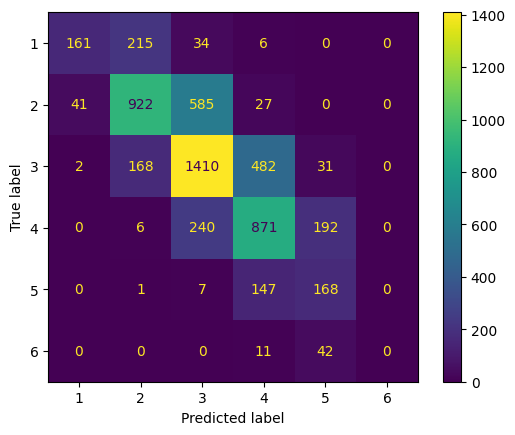

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    valid_dataset["labels"],
    valid_dataset["valid_pred"],
    labels=[x for x in range(1, 7)],
)

draw_cm = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[x for x in range(1, 7)]
)

draw_cm.plot()
plt.savefig(f"{MODEL_OUTPUT_PATH}/confusion_matrix.png")
plt.show()

# AWSへのアップロード

In [39]:
# S3へのアップロード
if not DEBUG and UPLOAD_DATA_TO_S3:
    # uninstall
    !sudo rm /usr/bin/aws
    !sudo rm /usr/bin/aws_completer
    !sudo rm -rf /usr/local/aws-cli

    # install
    !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    !unzip -o -qq awscliv2.zip
    !sudo ./aws/install --update

    # upload
    output_name = MODEL_OUTPUT_PATH.split("/")[-1]
    os.system(
        f"aws s3 cp --recursive {MODEL_OUTPUT_PATH} s3://automated-essay-scoring/trained_model/{output_name}"
    )

In [ ]:
# ダウンロード（参考）
# !sudo rm /usr/bin/aws
# !sudo rm /usr/bin/aws_completer
# !sudo rm -rf /usr/local/aws-cli

# !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
# !unzip -o -qq awscliv2.zip
# !sudo ./aws/install --update

# !aws s3 cp --recursive s3://automated-essay-scoring/trained_model/e005-regression /notebooks/automated_essay_scoring/trained_models/e005-regression

# Kaggle Datasetへのupload

In [40]:
if not DEBUG and UPLOAD_DATA_TO_KAGGLE:
    import os
    import json

    from kaggle.api.kaggle_api_extended import KaggleApi

    def dataset_create_new(dataset_name: str, upload_dir: str):
        # if "_" in dataset_name:
        #     raise ValueError("datasetの名称に_の使用は禁止です")
        dataset_metadata = {}
        dataset_metadata["id"] = f"sinchir0/{dataset_name}"
        dataset_metadata["licenses"] = [{"name": "CC0-1.0"}]
        dataset_metadata["title"] = dataset_name
        with open(os.path.join(upload_dir, "dataset-metadata.json"), "w") as f:
            json.dump(dataset_metadata, f, indent=4)
        api = KaggleApi()
        api.authenticate()
        api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode="tar")

    print(f"Create Dataset name:{DATASET_NAME}, output_dir:{MODEL_OUTPUT_PATH}")
    dataset_create_new(dataset_name=DATASET_NAME, upload_dir=MODEL_OUTPUT_PATH)

# ローカルからのデータの削除

In [41]:
if not DEBUG and (UPLOAD_DATA_TO_S3 or UPLOAD_DATA_TO_KAGGLE):
    # ローカルからは削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}")

In [42]:
if WANDB:
    wandb.finish()

In [43]:
print("finish Notebook!")

finish Notebook!
